# About Dataset
This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social, and school-related features, and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

## Source
Paulo Cortez, University of Minho, Guimarães, Portugal, [http://www3.dsi.uminho.pt/pcortez](http://www3.dsi.uminho.pt/pcortez)

# Attributes
## Attributes for both Math and Portuguese language course datasets
1. **id** - unique record id matching one student (numeric)
2. **school** - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
3. **sex** - student's sex (binary: "F" - female or "M" - male)
4. **age** - student's age (numeric: from 15 to 22)
5. **address** - student's home address type (binary: "U" - urban or "R" - rural)
6. **famsize** - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
7. **Pstatus** - parent's cohabitation status (binary: "T" - living together or "A" - apart)
8. **Medu** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. **Fedu** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
10. **Mjob** - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. **Fjob** - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
12. **reason** - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
13. **guardian** - student's guardian (nominal: "mother", "father" or "other")
14. **traveltime** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
15. **studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
16. **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)
17. **schoolsup** - extra educational support (binary: yes or no)
18. **famsup** - family educational support (binary: yes or no)
19. **paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
20. **activities** - extra-curricular activities (binary: yes or no)
21. **nursery** - attended nursery school (binary: yes or no)
22. **higher** - wants to take higher education (binary: yes or no)
23. **internet** - Internet access at home (binary: yes or no)
24. **romantic** - with a romantic relationship (binary: yes or no)
25. **famrel** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
26. **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)
27. **goout** - going out with friends (numeric: from 1 - very low to 5 - very high)
28. **Dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. **Walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
30. **health** - current health status (numeric: from 1 - very bad to 5 - very good)
31. **absences** - number of school absences (numeric: from 0 to 93)

## Grades (targets)
These grades are related to the course subject, Math or Portuguese:
- **G1** - first period grade (numeric: from 0 to 20)
- **G2** - second period grade (numeric: from 0 to 20)
- **G3** - final grade (numeric: from 0 to 20, output target)


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from scipy.stats import skew

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import xgboost as xgb

from yellowbrick.model_selection import ValidationCurve

## 1.0 Loading the Data
The unnecessary columns/rows were manually stripped in Excel

In [11]:
path = "../data/student_performance.xlsx"
portuguese_df = pd.read_excel(path, sheet_name="portuguese")
math_df = pd.read_excel(path, sheet_name="math")

Add a feature indicating, which subject the data corresponds to

In [12]:
portuguese_df["subject"] = "portuguese"
math_df["subject"] = "math"

# Combine the two
df = pd.concat([portuguese_df, math_df], ignore_index=True)

## 2.1 Exploratory Data Analysys

In [13]:
df

,id,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,56,GP,F,15.0,U,GT3,A,4.0,3.0,services,...,3.0,2.0,1.0,1.0,1.0,0.0,15,14,15,portuguese
1,192,GP,M,16.0,R,GT3,T,4.0,2.0,teacher,...,3.0,3.0,3.0,4.0,3.0,8.0,10,9,11,portuguese
2,494,MS,F,16.0,R,LE3,T,1.0,2.0,at_home,...,4.0,5.0,1.0,3.0,3.0,0.0,8,9,9,portuguese
3,404,GP,F,17.0,U,GT3,T,2.0,1.0,services,...,3.0,5.0,2.0,4.0,4.0,4.0,12,16,16,portuguese
4,355,GP,F,17.0,U,GT3,T,2.0,3.0,other,...,2.0,1.0,1.0,1.0,3.0,2.0,11,12,14,portuguese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,184,GP,F,16.0,U,GT3,T,3.0,2.0,other,...,2.0,2.0,1.0,2.0,1.0,14.0,12,13,12,math
1145,67,GP,F,16.0,U,GT3,T,3.0,1.0,services,...,3.0,3.0,1.0,2.0,5.0,4.0,7,7,6,math
1146,326,GP,M,17.0,U,GT3,T,3.0,3.0,other,...,3.0,5.0,3.0,5.0,5.0,3.0,14,15,16,math
1147,25,GP,F,16.0,U,GT3,T,2.0,2.0,services,...,2.0,2.0,1.0,3.0,5.0,14.0,6,9,8,math


The data set has 1149 observations and 35 features per observation

Firstly lets drop the id column since a unique record id doesn't provide us with any extra information and remove any duplicates

In [14]:
df = df.drop("id", axis=1)
df = df.drop_duplicates()
df.shape

(1044, 34)

Now our dataset contains 1044 unique observations and 33 features

Next we will look at the missing values of the dataset

In [15]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

age            8
address        3
famsize        7
Pstatus       10
Medu          10
Fedu           9
Mjob           4
Fjob           6
reason         9
guardian       6
traveltime     5
studytime      6
failures       7
schoolsup      5
famsup         5
paid           7
activities    13
nursery       10
higher         5
internet       8
romantic      10
famrel         7
freetime       1
goout          9
Dalc          14
Walc           4
health         5
absences       7
dtype: int64

We can see that quite a few columns have missing values, on the other hand there are not a lot of them ~1% at most per column, we will deal with these missing values later on 

Next we can look at the types

In [16]:
df.dtypes

school         object
sex            object
age           float64
address        object
famsize        object
Pstatus        object
Medu          float64
Fedu          float64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime    float64
studytime     float64
failures      float64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel        float64
freetime      float64
goout         float64
Dalc          float64
Walc          float64
health        float64
absences      float64
G1              int64
G2              int64
G3              int64
subject        object
dtype: object

We will firstly explore the **categorical columns** - those which have a dtype of 'object'  
We are going to list them out along with their unique values in order to later decide how can we transform them to fit our models needs

In [17]:
categorical_columns = df.select_dtypes(include=["object"]).columns

for col in categorical_columns:
    # Omit the NaN values
    print(f"{col}: {df[df[col].notnull()][col].unique()}") 

school: ['GP' 'MS']
sex: ['F' 'M']
address: ['U' 'R']
famsize: ['GT3' 'LE3']
Pstatus: ['A' 'T']
Mjob: ['services' 'teacher' 'at_home' 'other' 'health']
Fjob: ['services' 'other' 'health' 'teacher' 'at_home']
reason: ['reputation' 'other' 'course' 'home']
guardian: ['mother' 'father' 'other']
schoolsup: ['no' 'yes' 'não' '0' 'sim']
famsup: ['yes' 'no' 'não' '1' 'sim' '0']
paid: ['no' '0' 'yes' 'não' 'sim' '1']
activities: ['yes' 'no' 'não' '1' '0' 'sim']
nursery: ['yes' 'no' 'não' 'sim' '1' '0']
higher: ['yes' 'no' '1' 'sim' 'não']
internet: ['yes' 'no' 'sim' '1' '0' 'não']
romantic: ['no' 'yes' '0' 'não' 'sim' '1']
subject: ['portuguese' 'math']


Some of the "binary" columns seem to be inconsistent - they contain english/portugees words corresponding to true and false along with 0's and 1's
There are other columns, which only take 2 unique values that can be interpreted as "binary"  
And finally several that take more than 2 unqiue values, we will discuss how to represent these in the preprocessing step

For the sake of visualizations, we will fix the inconsistent columns

In [18]:
transformation_dict = {
    "yes": "yes", "1": "yes", "sim": "yes",
    "no": "no", "0": "no", "não": "no"
}

inconsistent_columns = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
df[inconsistent_columns] = df[inconsistent_columns].apply(lambda col: col.map(transformation_dict))

Now we can visualize these columns, starting with those which have only two unique values

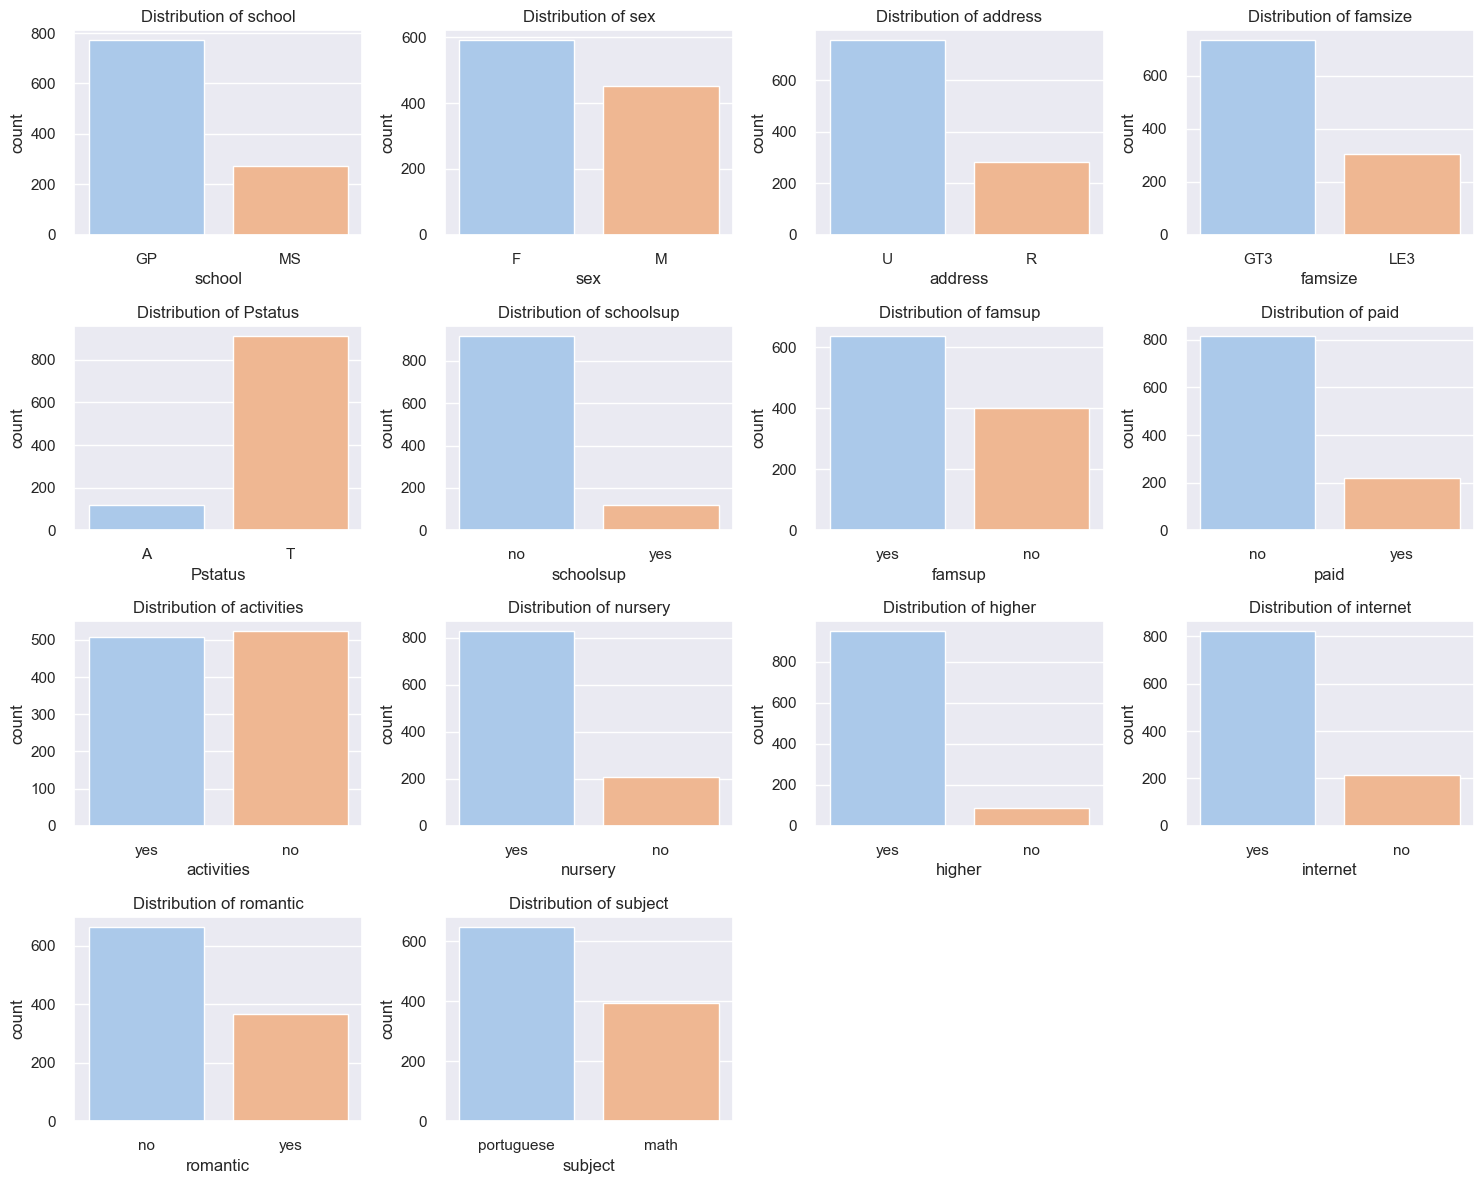

In [19]:
sns.set()
sns.set_palette("pastel")
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) == 2:
        plt.subplot(4, 4, index)
        sns.countplot(data=df, x=col, legend=False, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

We can see that some of the columns such as 'activities' are balanced and other like 'Pstatus', 'higher' ... are tipped to one side

Lets also visualize the categorical columns, which have more than 2 unique values

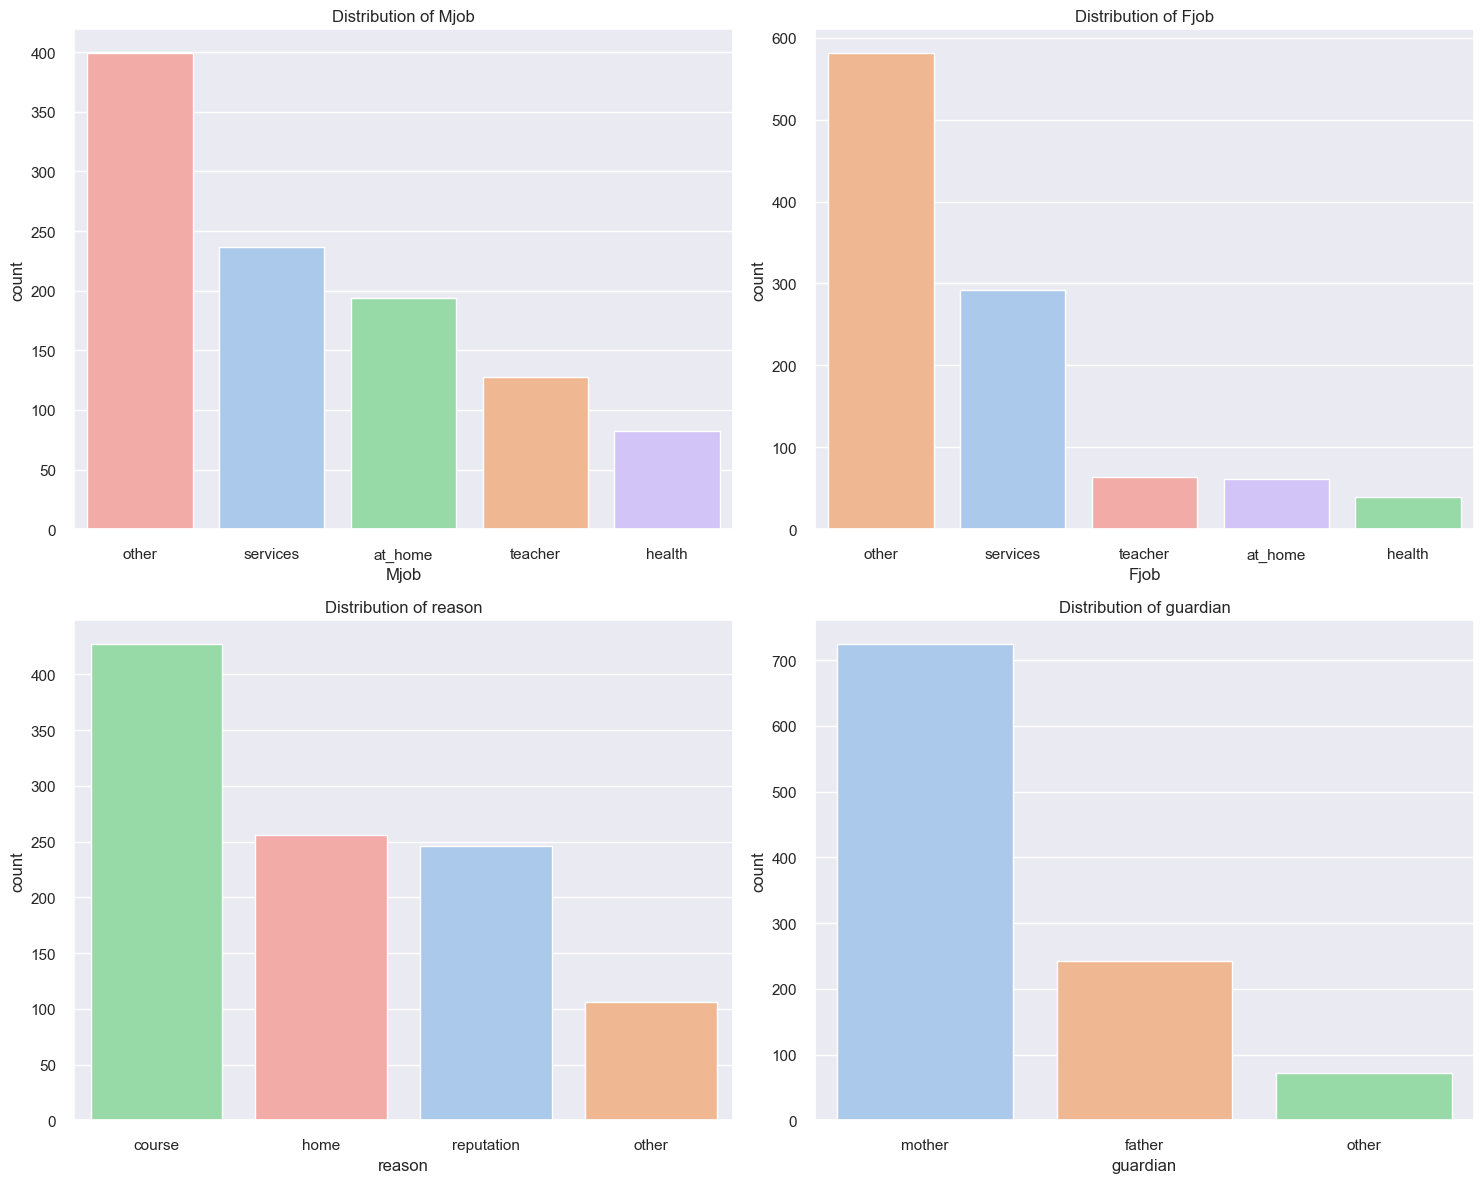

In [20]:
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) > 2:
        order = column.value_counts().index
        plt.subplot(2, 2, index)
        sns.countplot(data=df, x=col, legend=False, order=order, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

Here are some interesting insights:
- The majority of the students' mothers are either staying at home or working in service jobs.
- Most of the students' fathers work in service jobs.
- The primary reason for choosing a particular school is course preference.
- The student's guardian is most commonly his mother.

Next, we will take a closer look at **numeric columns**, starting with a basic summary  
We won't consider the id column, since it has no information value for us

In [21]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
target_columns = ["G1", "G2","G3"]
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1036.0,16.726834,1.241666,15.0,16.0,17.0,18.0,22.0
Medu,1034.0,2.596712,1.123036,0.0,2.0,3.0,4.0,4.0
Fedu,1035.0,2.392271,1.101581,0.0,1.0,2.0,3.0,4.0
traveltime,1039.0,1.524543,0.732618,1.0,1.0,1.0,2.0,4.0
studytime,1038.0,1.972062,0.834519,1.0,1.0,2.0,2.0,4.0
failures,1037.0,0.265188,0.657650,0.0,0.0,0.0,0.0,3.0
famrel,1037.0,3.936355,0.930914,1.0,4.0,4.0,5.0,5.0
freetime,1043.0,3.201342,1.031983,1.0,3.0,3.0,4.0,5.0
goout,1035.0,3.158454,1.155264,1.0,2.0,3.0,4.0,5.0
Dalc,1030.0,1.488350,0.905313,1.0,1.0,1.0,2.0,5.0


Some interesting obervations are
- Failures varianble is highly imbalanced with most students having 0 failures
- Target variables G1, G2 and G2 exhibit similar values

We can also look at the distributions

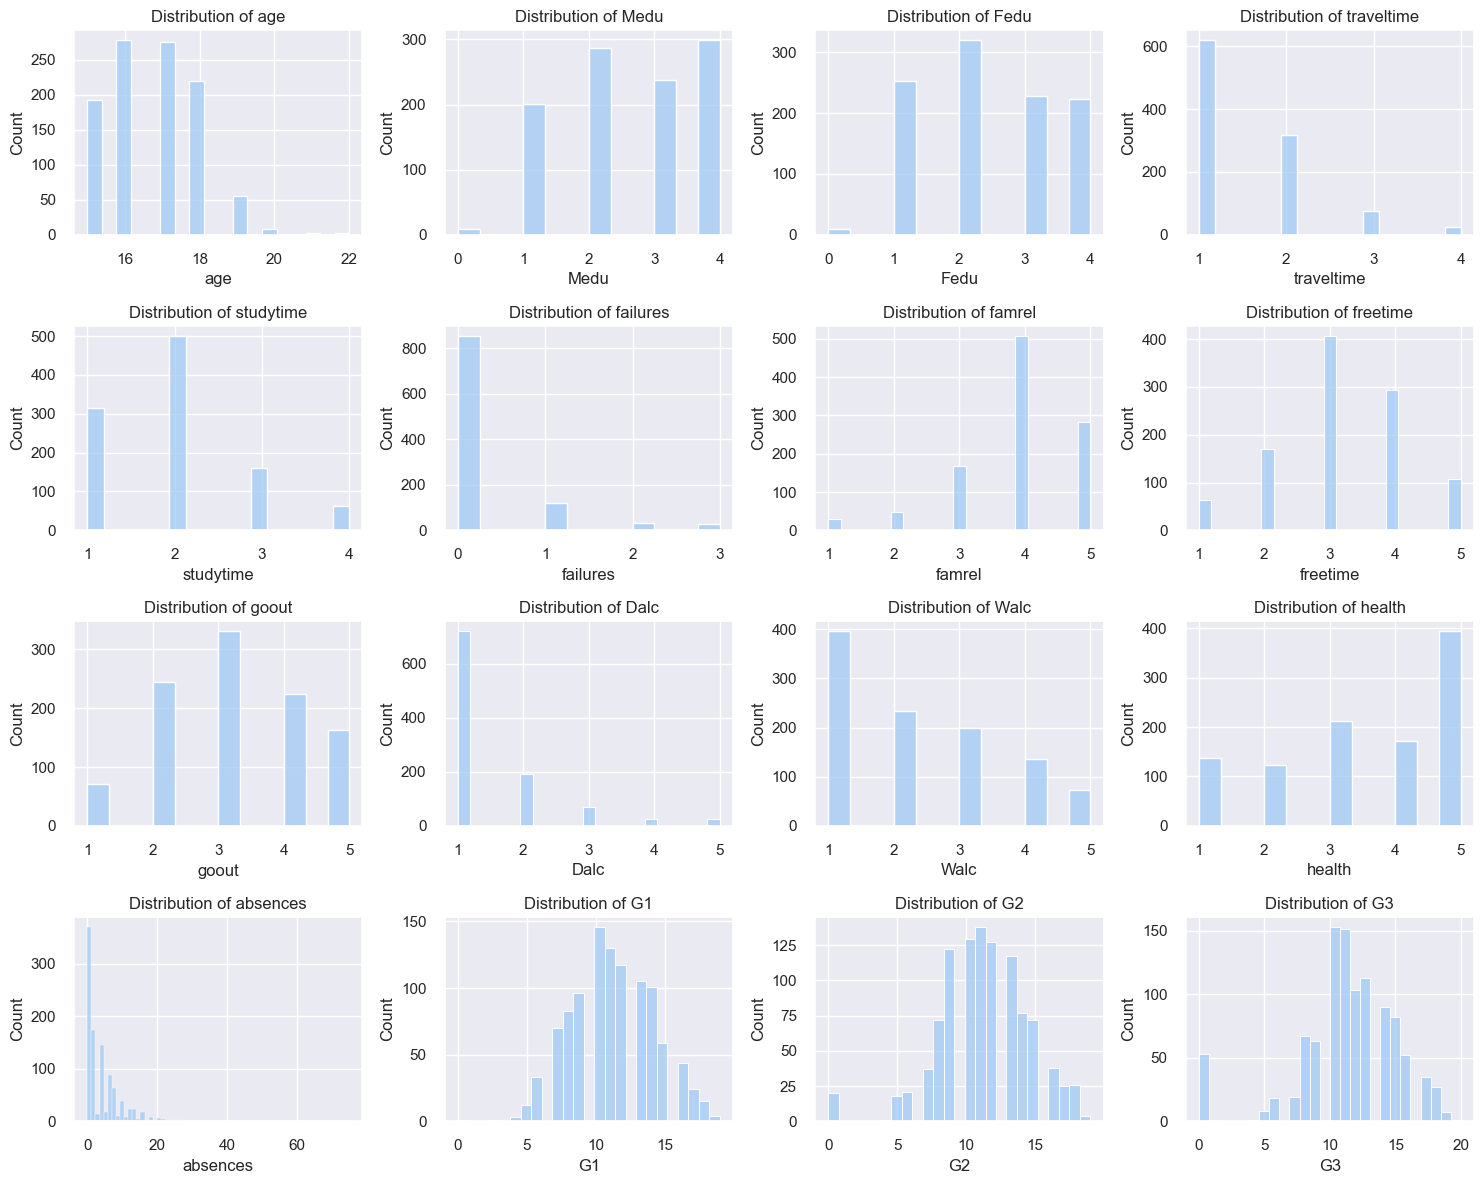

In [23]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

We can also visualize the distributions using boxplots

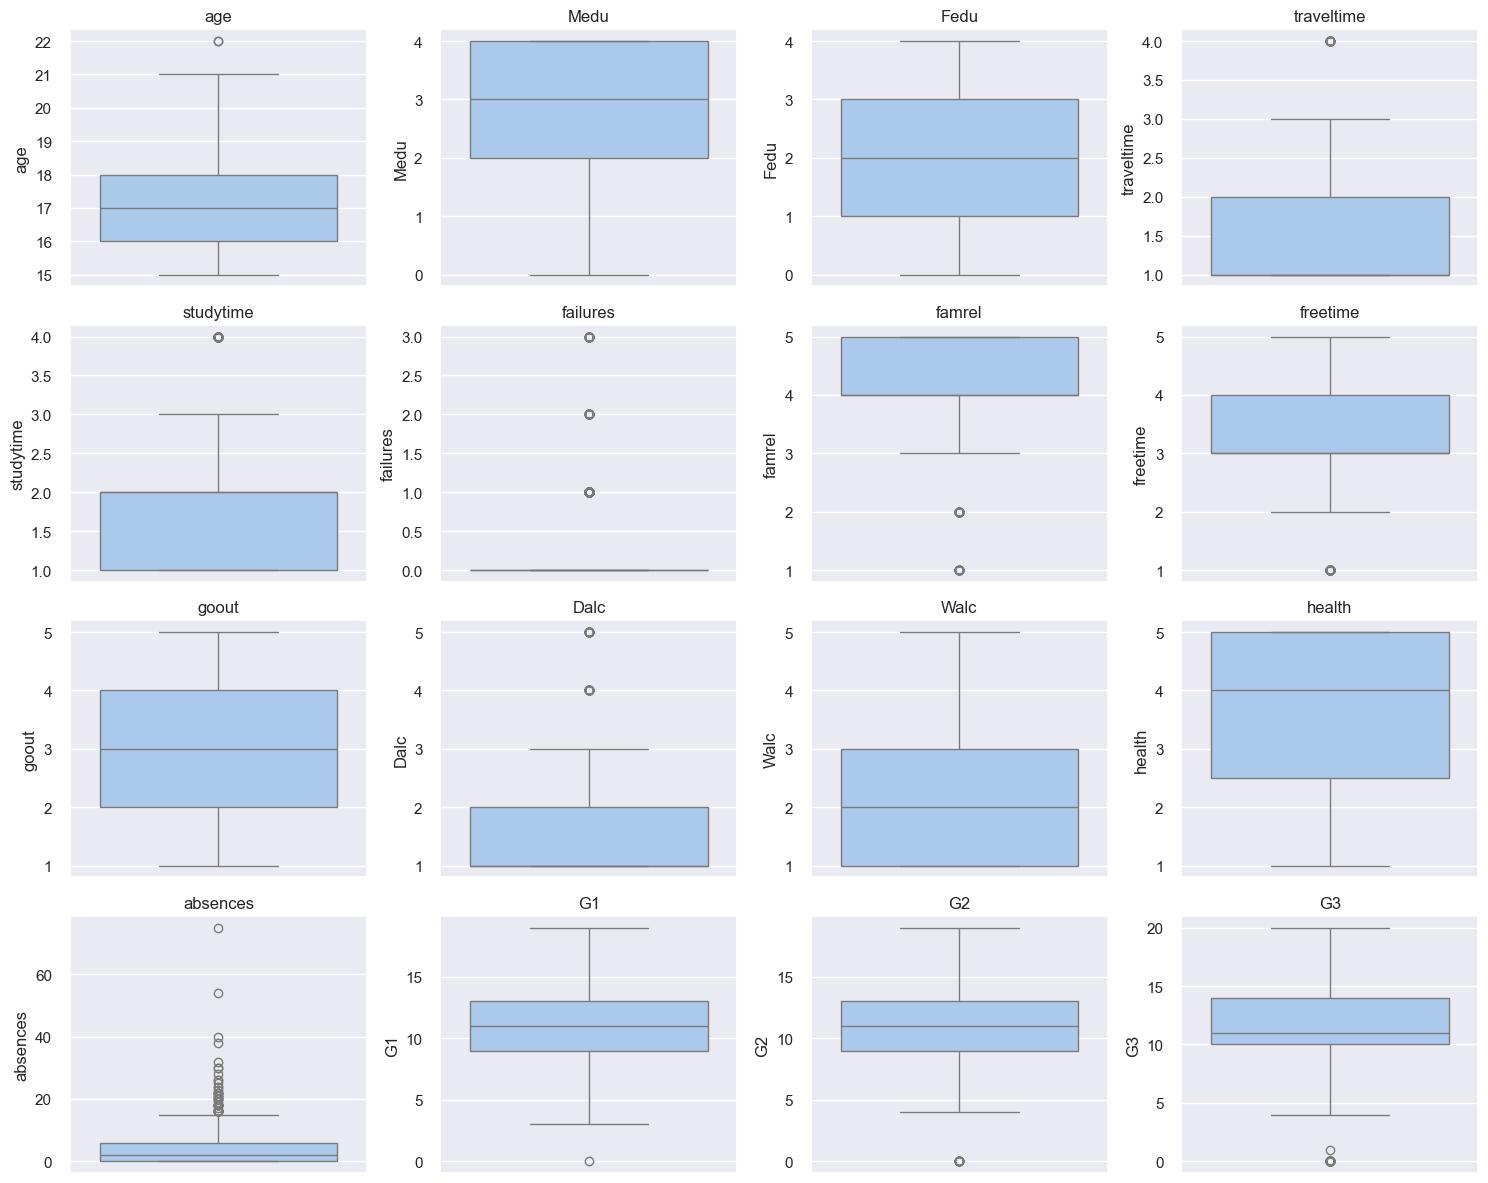

In [24]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"{col}")
    
plt.tight_layout()
plt.show()

We will also look at linear relationships using a correlation heatmap

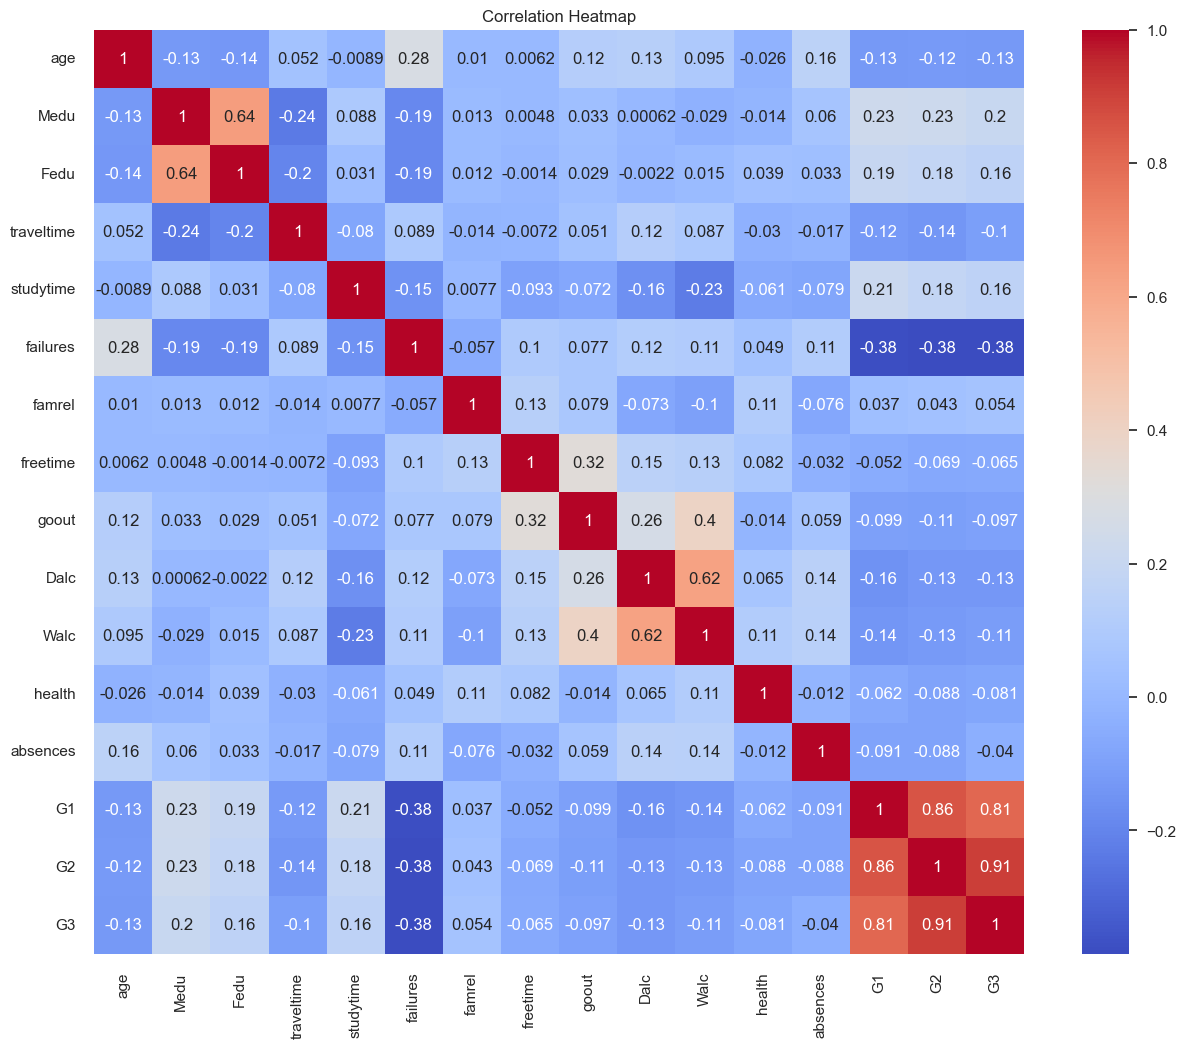

In [25]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Target variables G1, G2 and G3 have a strong positive correlation  
Variables describing the workday and weekend alcohol consumption also exhibit a positive correlation, this also applies to father's and mother's education

The strongest negative correlation is between the grades and the number of failures, meaning that people who fail are more likely to get a worst grade

## 2.2 Preprocessing

In [90]:
# Checkpoint to reset preprocessing

df = pd.read_excel("../data/unprocessed.xlsx")
assert df.shape == (1044, 34)

As our first preprocessing step, we will change the dtype from 'object' to 'category'

In [91]:
for col in categorical_columns:
    df[col] = df[col].astype("category")
    
df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      1044 non-null   category
 1   sex         1044 non-null   category
 2   address     1041 non-null   category
 3   famsize     1037 non-null   category
 4   Pstatus     1034 non-null   category
 5   Mjob        1040 non-null   category
 6   Fjob        1038 non-null   category
 7   reason      1035 non-null   category
 8   guardian    1038 non-null   category
 9   schoolsup   1039 non-null   category
 10  famsup      1039 non-null   category
 11  paid        1037 non-null   category
 12  activities  1031 non-null   category
 13  nursery     1034 non-null   category
 14  higher      1039 non-null   category
 15  internet    1036 non-null   category
 16  romantic    1034 non-null   category
 17  subject     1044 non-null   category
dtypes: category(18)
memory usage: 20.9 KB


### Missing Values

For categorical data, we will use SimpleImputer with "most frequent" strategy

In [92]:
simple_imputer = SimpleImputer(strategy="most_frequent")

for col in categorical_columns:
    df[[col]] = simple_imputer.fit_transform(df[[col]])

For numeric variables, since there are not a lot of missing data IterativeImputer would be the best choice

In [93]:
iterative_imputer = IterativeImputer()

for col in numeric_columns:
    df[[col]] = iterative_imputer.fit_transform(df[[col]])
    
# Check that there are no more missing values in our dataset
missing_values = df.isnull().sum()
assert len(missing_values[missing_values > 0]) == 0

### Encoding

We will use a LabelEncoder for "binary" columns

In [94]:
label_encoder = LabelEncoder()
binary_columns = [col for col in categorical_columns if len(df[df[col].notnull()][col].unique()) == 2]

for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])
    
df[binary_columns].head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,subject
0,0,0,1,0,0,0,1,0,1,1,1,1,0,1
1,0,1,0,0,1,0,1,0,1,1,1,1,1,1
2,1,0,0,1,1,0,0,0,1,1,0,1,0,1
3,0,0,1,0,1,0,1,0,1,1,1,1,0,1
4,0,0,1,0,1,0,0,0,1,1,1,1,1,1


And OneHotEncoder for columns that have more than 2 unique values

In [95]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
nonbinary_columns = [col for col in categorical_columns if col not in binary_columns]

one_hot_encoded_data = one_hot_encoder.fit_transform(df[nonbinary_columns])
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(nonbinary_columns)

# Create a df from the encoded data and columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoded_columns)

# Transform the original df
df = pd.concat([df.drop(columns=nonbinary_columns), one_hot_encoded_df], axis=1)

In [96]:
df.shape

(1044, 47)

We have transformed the original 4 "nonbinary" categorical columns to 17 new encoded ones

### Scaling the Data

Lets continue with scaling our data, we will use a Standard Scaler

In [97]:
exclude_cols = ["G1", "G2", "G3"]
scale_cols = [col for col in df.columns if col not in exclude_cols]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

### Splitting the Data

In [98]:
X, y = df.drop(columns=["G1", "G2", "G3"]), df["G3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape} {y_train.shape}")
print(f"Test  shape: {X_test.shape} {y_test.shape}")

Train shape: (835, 44) (835,)
Test  shape: (209, 44) (209,)


### Feature Selection

We will use Ridge Regression model for Feature Selection and perform selection of k-best features. We will use two different score functions:
- correlation feature selection using f_regression
- mutual information feature selection (typically used in the construction of decision trees)

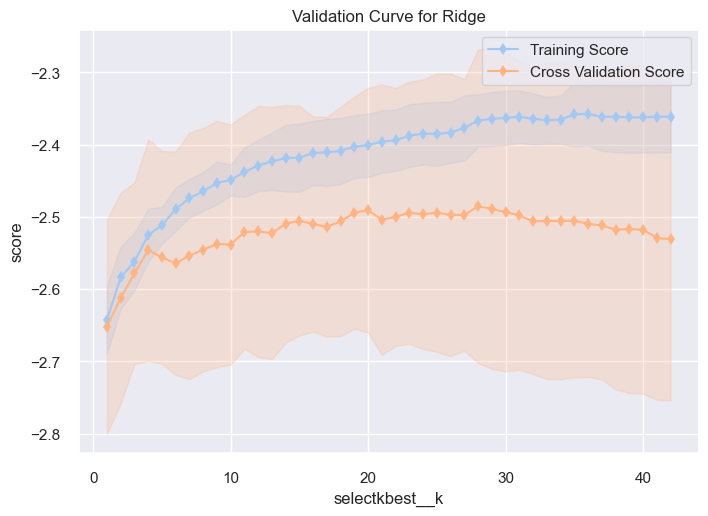

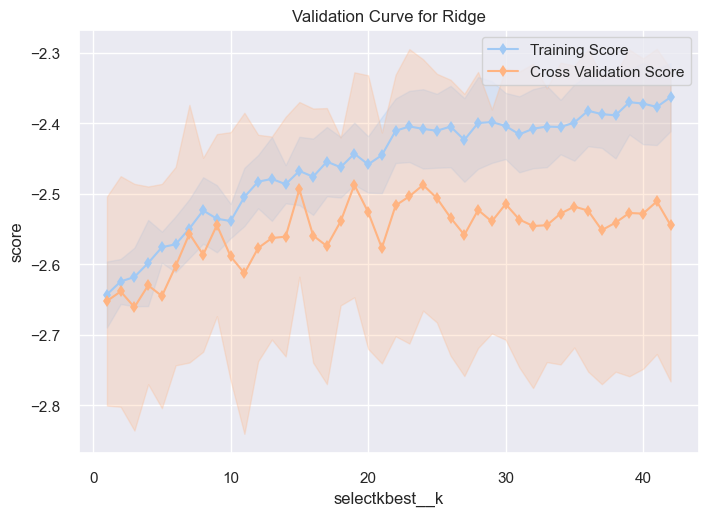

In [99]:
for score_func in [f_regression, mutual_info_regression]:
    
    kbest_pipeline = make_pipeline(
        SelectKBest(score_func=score_func),
        Ridge()
    )
    
    viz = ValidationCurve(
        kbest_pipeline,
        param_name="selectkbest__k",
        param_range=np.arange(1, 43),
        cv=5,
        scoring="neg_mean_absolute_error",
    )
    
    viz.fit(X_train, y_train)
    viz.show()
    plt.show()

In [100]:
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)

mask = selector.get_support()
selected_features = X_train.columns[mask]

X_train = pd.DataFrame(selector.transform(X_train), columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(selector.transform(X_test), columns=selected_features, index=X_test.index)

### Baseline Model

In [101]:
for strategy in ["mean", "median"]:
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(X_train, y_train)
    dummy_pred = dummy_regr.predict(X_test)
    print(f"RMSE using strategy {strategy}: {root_mean_squared_error(y_test, dummy_pred):.3f}")

RMSE using strategy mean: 3.661
RMSE using strategy median: 3.700


## 2.3 XGBoost Regressor
https://xgboost.readthedocs.io/en/release_3.0.0/

## 2.4 Explaining the Model

XGBoost (eXtreme Gradient Boosting) is an advanced machine learning technique based on gradient-boosted decision trees. During training, the model builds an ensemble of weak prediction trees sequentially, where each new tree corrects errors made by the previous ones. The algorithm optimizes a user-defined loss function (e.g., mean squared error for regression or log loss for classification) while incorporating regularization terms (L1/L2 penalties) to prevent overfitting. Key computations include calculating gradients (first-order derivatives) and Hessians (second-order derivatives) of the loss function, which guide the tree-building process by determining optimal splits that minimize the overall loss.

The result of training is a weighted ensemble of decision trees, where each tree contributes a prediction adjusted by a learning rate (shrinkage factor). Unlike random forests, which grow trees independently, XGBoost iteratively refines predictions by focusing on residual errors, leading to higher accuracy. The final model combines predictions from all trees, balancing bias and variance through techniques like pruning, early stopping, and cross-validation. XGBoost’s efficiency stems from its parallelizable tree construction and handling of sparse data, making it a powerful tool for structured datasets.

## 2.5 Training the Model
Converting data into DMatrix, which is optimized for XGBoost

In [102]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#### First Run
With early stopping round to prevent overfitting

In [103]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10
)

y_pred = model.predict(dtest)

print("\nModel Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

[0]	train-rmse:3.41984	test-rmse:3.43435
[10]	train-rmse:1.99436	test-rmse:3.38653
[20]	train-rmse:1.54362	test-rmse:3.42970
[30]	train-rmse:1.29892	test-rmse:3.45680
[40]	train-rmse:1.06109	test-rmse:3.49887
[50]	train-rmse:0.83789	test-rmse:3.51103

Model Evaluation:
RMSE: 3.5105
MAE: 2.5724
R2: 0.0679


#### Hyperparameter Tuning

In [119]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "max_depth": [3, 5],                    # shallower trees to reduce overfitting
    "learning_rate": [0.05, 0.1],           # slower learning
    "subsample": [0.8, 1.0],                # fewer options to reduce search
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],                      # small regularization
    "min_child_weight": [1, 5],             # keep light to medium regularization
    "reg_alpha": [0, 0.1],                  # L1: slight regularization
    "reg_lambda": [0.1, 1]                  # L2: keep strong regularization
}


grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    n_iter=300
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
print("\nTuned Model Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_tuned)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_tuned):.4f}")
print(f"R2: {r2_score(y_test, y_pred_tuned):.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 256 is smaller than n_iter=300. Running 256 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

Tuned Model Evaluation:
RMSE: 3.3796
MAE: 2.4641
R2: 0.1361


#### Feature Importance

<Figure size 1000x600 with 0 Axes>

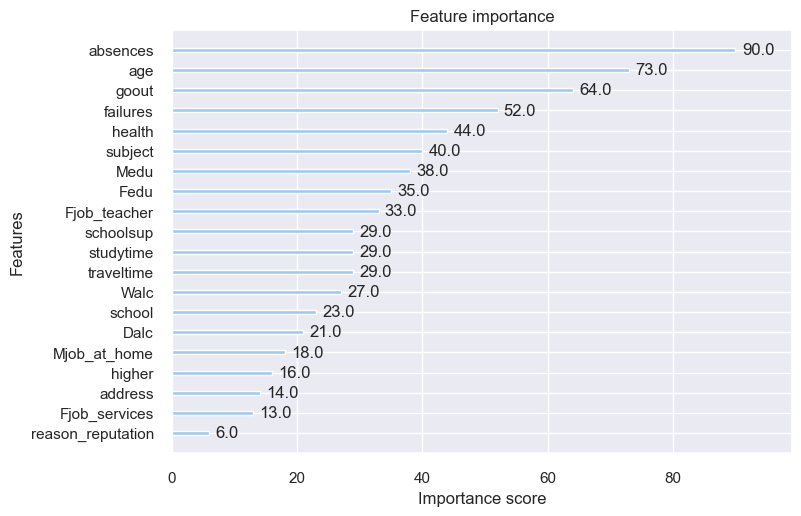

In [120]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model.get_booster(), importance_type="weight")
plt.show()

/var/folders/r_/wm3dlswj09572h0q__6zv3280000gn/T/ipykernel_13437/1435686910.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


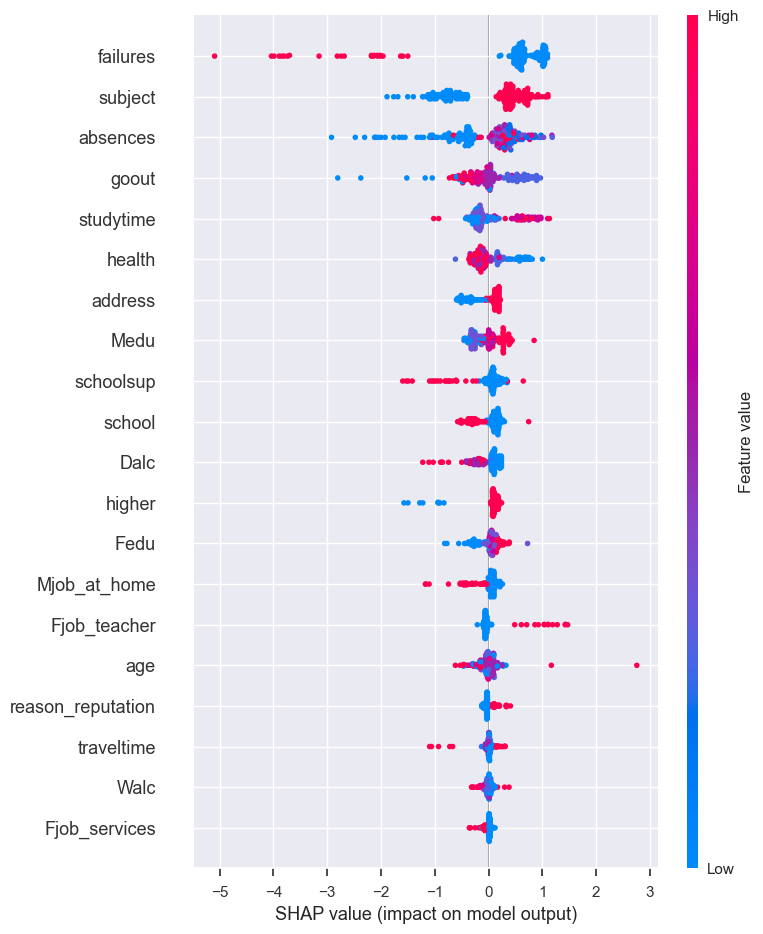

In [121]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.show()

#### Learning Curve

Best CV RMSE: 3.1807
At round: 51


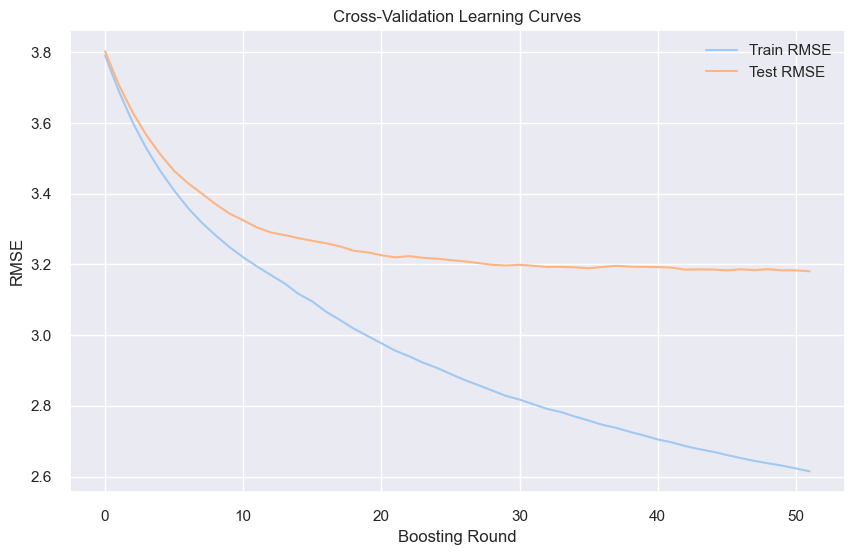

In [124]:
cv_results = xgb.cv(
    grid_search.best_params_,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds=10,
    seed=42,
    shuffle=True
)

print(f"Best CV RMSE: {cv_results['test-rmse-mean'].min():.4f}")
print(f"At round: {cv_results['test-rmse-mean'].argmin()}")

plt.figure(figsize=(10, 6))
plt.plot(cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results['test-rmse-mean'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Cross-Validation Learning Curves')
plt.legend()
plt.show()

In [123]:
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    n_estimators=30
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print("\nTuned Model Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")


Tuned Model Evaluation:
RMSE: 3.3022
MAE: 2.4478
R2: 0.1752
